In [ ]:
!pip install cudaq==0.10.0 qiskit==1.3.2 scipy==1.15.1 pyscf==2.8.0 pylatexenc -q


In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np
from pyscf import gto, scf, ao2mo, mcscf
import cudaq
from cudaq import spin
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
def generate_excitation_pairs(nocc, num_orbitals):

    excitation_pairs = []
    for occupied in range(nocc):
        for virtual in range(nocc, num_orbitals):
            excitation_pairs.append((occupied, virtual))

    flatenned_ep = [x for pair in excitation_pairs for x in pair]

    return excitation_pairs, flatenned_ep


In [ ]:
def setup_molecule(atom_string, basis_set, charge, spin):
    print("Molecule Geometry:", atom_string)
    print("Basis Set:", basis_set)

    molecule = gto.M(atom=atom_string, basis=basis_set, charge=charge, spin=spin, unit="angstrom", verbose=0)
    molecule.build()

    return molecule

In [ ]:
def calculate_integrals(molecule, active_space=None):
    mean_field = scf.RHF(molecule)
    mean_field.kernel()

    new_orbitals, _, stable, _ = mean_field.stability(return_status=True)
    new_1rdm = mean_field.make_rdm1(new_orbitals, mean_field.mo_occ)
    mean_field = mean_field.newton()
    mean_field.kernel(new_1rdm)
    print(f"SCF energy = {mean_field.e_tot}")

    if active_space is not None:
      assert len(active_space) == 2

      nelec = active_space[0]
      norbs = active_space[1]

      mc = mcscf.CASCI(mean_field, norbs, nelec)

      one_electron_integrals, core_energy = mc.get_h1eff()
      two_electron_integrals = mc.get_h2eff()
      two_electron_integrals = ao2mo.restore("s1", two_electron_integrals, one_electron_integrals.shape[0])
      num_electrons = nelec

    else:

      one_electron_integrals = mean_field.get_hcore()
      two_electron_integrals = mean_field._eri

      one_electron_integrals = np.einsum('pi,pq,qj->ij', mean_field.mo_coeff, one_electron_integrals, mean_field.mo_coeff)
      two_electron_integrals = ao2mo.kernel(two_electron_integrals, mean_field.mo_coeff)

      core_energy = mean_field.energy_nuc()
      num_electrons = molecule.nelectron

      two_electron_integrals = ao2mo.restore("s1", two_electron_integrals, one_electron_integrals.shape[0])

    print(f"Core Energy: {core_energy:.8f} Ha")
    print(f"Number of Electrons: {num_electrons}")

    return one_electron_integrals, two_electron_integrals, core_energy, num_electrons


In [ ]:
def spo2spin(spo: SparsePauliOp):
    """Convert Qiskit SparsePauliOp to CUDA-Q SpinOperator."""
    return sum(coeff * cudaq.SpinOperator.from_word(pauli) for pauli, coeff in spo.label_iter())


def build_hamiltonian(core_energy, one_electron_integrals, two_electron_integrals):
    num_orbitals = len(one_electron_integrals)

    def I():
        return "I" * num_orbitals
    def Z(p):
        return ("I" * p) + "Z" + ("I" * (num_orbitals - p - 1))
    def ZZ(p, q):
        return ("I" * min(p, q)) + "Z" + ("I" * (abs(p - q) - 1)) + "Z" + ("I" * (num_orbitals - max(p, q) - 1))
    def XX(p, q):
        return ("I" * min(p, q)) + "X" + ("I" * (abs(p - q) - 1)) + "X" + ("I" * (num_orbitals - max(p, q) - 1))
    def YY(p, q):
        return ("I" * min(p, q)) + "Y" + ("I" * (abs(p - q) - 1)) + "Y" + ("I" * (num_orbitals - max(p, q) - 1))

    terms = []
    terms.append((I(), core_energy))

    modified_one_body = one_electron_integrals - 0.5 * np.einsum("prrq->pq", two_electron_integrals) + np.einsum("ppqq->pq", two_electron_integrals)

    for p in range(num_orbitals):
        terms.append((I(), modified_one_body[p, p]))
        terms.append((Z(p), -modified_one_body[p, p]))

        for q in range(num_orbitals):
            if p != q:
                terms.append((I(), 0.5 * two_electron_integrals[p, p, q, q] + 0.25 * two_electron_integrals[p, q, q, p]))
                terms.append((Z(p), -0.5 * two_electron_integrals[p, p, q, q] - 0.25 * two_electron_integrals[p, q, q, p]))
                terms.append((Z(q), -0.5 * two_electron_integrals[p, p, q, q] + 0.25 * two_electron_integrals[p, q, q, p]))
                terms.append((ZZ(p, q), 0.5 * two_electron_integrals[p, p, q, q] - 0.25 * two_electron_integrals[p, q, q, p]))
                terms.append((XX(p, q), 0.25 * two_electron_integrals[p, q, p, q]))
                terms.append((YY(p, q), 0.25 * two_electron_integrals[p, q, p, q]))

    sparse_pauli_op_list = [SparsePauliOp(label, coefficient) for label, coefficient in terms]
    qiskit_h = SparsePauliOp.sum(sparse_pauli_op_list).simplify()

    cudaq_h = spo2spin(qiskit_h)


    return qiskit_h, cudaq_h



In [ ]:
def create_ansatz(nocc, num_orbitals, excitation_pairs):

    circuit = QuantumCircuit(num_orbitals)

    parameters = ParameterVector('θ', len(excitation_pairs))

    for i in range(nocc):
        circuit.x(i)


    for index, (i, a) in enumerate(excitation_pairs):

        theta = parameters[index]
        circuit.s(i)
        circuit.s(a)
        circuit.h(a)
        circuit.cx(a, i)
        circuit.ry(theta, i)
        circuit.ry(theta, a)
        circuit.cx(a, i)
        circuit.h(a)
        circuit.sdg(a)
        circuit.sdg(i)

    return circuit


In [ ]:
@cudaq.kernel
def kernel(nocc: int, num_orbitals: int, thetas: list[float], flattened_ep: list[int]):
    '''flattened_ep: cudaq does not accept list of tuples hence we use list of ints'''

    q = cudaq.qvector(num_orbitals)

    for i in range(nocc):
        x(q[i])

    index = 0
    for j in range(0, len(flattened_ep), 2):

        i, a = flattened_ep[j], flattened_ep[j + 1]

        s(q[i])
        s(q[a])
        h(q[a])
        cx(q[a], q[i])

        ry(thetas[index], q[i])
        ry(thetas[index], q[a])

        cx(q[a], q[i])
        h(q[a])
        s.adj(q[a])
        s.adj(q[i])

        index += 1

In [ ]:
#atom_string = "H 0 0 0; H 0 0 0.75"  #H2
# atom_string = "H 0 0 0; H 0 0 1; H 0 0 2; H 0 0 3" #H4
#atom_string = 'Li 0 0 1.596; H 0 0 0' #LiH
#atom_string = 'O 0.0 -0.064535289132 0.0; H 0.816994 0.512110935315 0.0; H -0.816994 0.512110935315 0.0' #H2O

# molecule B
atom_string = """
Ni         0.01087       -0.65034       -0.82192
P         -2.11214       -0.34418       -0.26552
P          1.28203        1.03861       -0.33963
C          1.20132       -1.99109       -1.53283
O         -0.03665       -2.40446       -1.42497
C          2.24029       -2.42578       -0.56130
C          3.59793       -2.18194       -0.81437
C          4.20131       -3.03680        1.36492
C          1.88519       -3.02003        0.65925
C          2.85488       -3.31682        1.61216
H          3.89145       -1.74659       -1.77460
H          4.95994       -3.26846        2.11574
H          0.82860       -3.22764        0.84174
H          2.56065       -3.77256        2.56099
C          2.49398        1.41965       -1.69188
C          0.55710        2.69169        0.08673
C          2.31701        0.64211        1.13840
C         -2.39241       -0.53396        1.56040
C         -2.85360        1.28411       -0.75583
C         -3.17221       -1.64013       -1.04980
H          1.96669        1.20535       -2.63559
H          3.26057        0.63088       -1.60119
H          2.76905       -0.33858        0.92618
H          1.59722        0.45366        1.95357
H         -0.13033        2.94971       -0.73711
H          1.34114        3.46536        0.09788
H         -2.35476        1.53214       -1.70805
H         -2.47198        2.02144       -0.03040
H         -2.51327       -2.52291       -1.09866
H         -3.30102       -1.32443       -2.09993
H         -1.46818       -0.17479        2.04124
H         -2.39896       -1.62333        1.73812
C          4.56898       -2.47561        0.14126
H          5.62137       -2.27113       -0.07118
H          1.59406       -1.76651       -2.54558
H          2.88434        2.41508       -1.65140
H          0.08173        2.64722        1.04430
H          3.03552        1.40151        1.36634
H         -3.27294       -0.03374        1.90585
H         -3.92220        1.26995       -0.80860
H         -4.10183       -1.80441       -0.54610
"""

# molecule BC
mol_bc_geometry = """
Ni        -0.20821       -0.95408        0.00558
P         -2.37070       -0.53276       -0.06785
P          1.08758        0.78556       -0.05782
C          1.06458       -2.28458        0.46662
O          0.68222       -2.39432        1.64814
C          2.49962       -2.36556        0.06722
C          2.85880       -2.55212       -1.27126
C          5.19044       -2.30843       -0.69430
C          3.49997       -2.18699        1.02936
C          4.83835       -2.14137        0.64729
H          2.07336       -2.69600       -2.01903
H          6.24111       -2.27787       -0.99195
H          3.20177       -2.07778        2.07438
H          5.61493       -1.98430        1.39973
C          2.50895        0.78837       -1.24987
C          0.22541        2.40863       -0.34766
C          1.82857        0.95422        1.63712
C         -2.88734        0.43138       -1.56959
C         -3.43355       -2.05643       -0.05052
C         -2.94845        0.46074        1.39083
H          2.11156        0.30017       -2.15530
H          3.23538        0.06972       -0.83891
H          1.83423       -0.07084        2.04357
H          1.07831        1.49261        2.24231
H         -0.78417        2.27182        0.07409
H          0.07648        2.48267       -1.43982
H         -2.88615       -2.75383        0.60532
H         -3.34526       -2.48716       -1.06390
H         -2.09632        1.10825        1.65615
H         -3.02093       -0.26415        2.22052
H         -2.20840        0.08471       -2.36628
H         -2.58279        1.47378       -1.36925
C          4.19831       -2.52880       -1.65131
H          4.47123       -2.67342       -2.69905
H          0.31522       -2.60661       -0.39764
H          2.92268        1.75996       -1.42232
H          0.75415        3.24576        0.05797
H          2.78699        1.42995        1.63332
H         -3.92606        0.33315       -1.80690
H         -4.44707       -1.87799        0.24247
H         -3.85493        0.99866        1.20692
"""

# molecule C
mol_c_geometry = """
Ni        -0.09499       -0.70961       -0.88163
P          0.83362        1.14737       -0.08457
P         -2.21681       -0.55889       -0.29118
C         -3.13605        0.95217       -0.87142
C          2.41999        0.79469        0.79744
C          1.25317        2.20721       -1.53618
C         -0.14241        2.21680        1.07659
C         -3.27261       -1.95663       -0.87463
C         -2.46042       -0.58283        1.54476
H         -3.57379        0.68046       -1.84732
H         -2.37412        1.71505       -1.10039
H         -2.80788       -2.86415       -0.45335
H         -3.08436       -2.02265       -1.95903
H         -3.52547       -0.72137        1.79189
H         -2.17907        0.41121        1.92629
H          0.31486        2.71529       -1.82141
H          1.46357        1.47721       -2.33672
H         -0.07886        1.72106        2.06204
H         -1.19262        2.10883        0.76309
H          3.12639        0.49904        0.00354
H          2.23399       -0.13627        1.35850
C          1.56619       -1.23037       -1.59752
C          2.42496       -2.19429       -0.79416
O          2.03514       -0.75266       -2.61890
C          1.89374       -2.90355        0.28578
C          4.06956       -3.82561        0.77679
C          3.78588       -2.31996       -1.09047
C          4.60631       -3.12853       -0.30802
H          0.82403       -2.81064        0.49554
H          4.71282       -4.45896        1.39257
H          4.17587       -1.76304       -1.94610
H          5.67011       -3.22016       -0.54079
C          2.70980       -3.71689        1.07017
H          2.28588       -4.26964        1.91204
H         -0.34070       -1.99890       -1.57653
H         -3.85827        1.28732       -0.15660
H          2.76064        1.60748        1.40426
H          2.04728        2.90226       -1.35955
H          0.19257        3.23288        1.09329
H         -4.30612       -1.84521       -0.62100
H         -1.87887       -1.37561        1.96687
"""

basis_set, charge, spin = "sto-3g", 0, 0
optimizer, maxiter = 'COBYLA', 200

cudaq.set_target('qpp-cpu', option = 'fp64')
estimator = StatevectorEstimator()

molecule = setup_molecule(mol_c_geometry, basis_set, charge, spin)
one_electron_integrals, two_electron_integrals, core_energy, num_electrons = calculate_integrals(molecule, active_space=(8,8))
qiskit_h, cudaq_h = build_hamiltonian(core_energy, one_electron_integrals, two_electron_integrals)

nocc = num_electrons // 2
num_orbitals = one_electron_integrals.shape[0]
print('number of qubits', num_orbitals)
excitation_pairs, flatenned_ep = generate_excitation_pairs(nocc, num_orbitals) #cudaq cant work with a list of tuples hence we use a flattened list

num_params = len(excitation_pairs)
initial_parameters = 0*np.random.normal(0, np.pi, num_params)


Molecule Geometry: 
Ni        -0.09499       -0.70961       -0.88163
P          0.83362        1.14737       -0.08457
P         -2.21681       -0.55889       -0.29118
C         -3.13605        0.95217       -0.87142
C          2.41999        0.79469        0.79744
C          1.25317        2.20721       -1.53618
C         -0.14241        2.21680        1.07659
C         -3.27261       -1.95663       -0.87463
C         -2.46042       -0.58283        1.54476
H         -3.57379        0.68046       -1.84732
H         -2.37412        1.71505       -1.10039
H         -2.80788       -2.86415       -0.45335
H         -3.08436       -2.02265       -1.95903
H         -3.52547       -0.72137        1.79189
H         -2.17907        0.41121        1.92629
H          0.31486        2.71529       -1.82141
H          1.46357        1.47721       -2.33672
H         -0.07886        1.72106        2.06204
H         -1.19262        2.10883        0.76309
H          3.12639        0.49904        0.00354


In [ ]:
circuit = create_ansatz(nocc, num_orbitals, excitation_pairs)

def qiskit_cost(params):
    job = estimator.run([(circuit, qiskit_h, params)])
    energy = job.result()[0].data.evs.item()
    return energy


qiskit_exp_vals = []
def q_callback(xk):
    qiskit_exp_vals.append(qiskit_cost(xk))


result = minimize(qiskit_cost,
                  initial_parameters,
                  method=optimizer,
                  callback=q_callback,
                  options={'maxiter': maxiter})



In [ ]:
def cudaq_cost(theta_vals):
    exp_val = cudaq.observe(kernel, cudaq_h, nocc, num_orbitals, theta_vals, flatenned_ep).expectation()
    return exp_val

cudaq_exp_vals = []
def c_callback(xk):
    cudaq_exp_vals.append(cudaq_cost(xk))


result = minimize(cudaq_cost,
                  initial_parameters,
                  method=optimizer,
                  callback=c_callback,
                  options={'maxiter': maxiter})

Converged Qiskit energy = -2737.839601
Converged CUDA-Q energy = -2737.847556


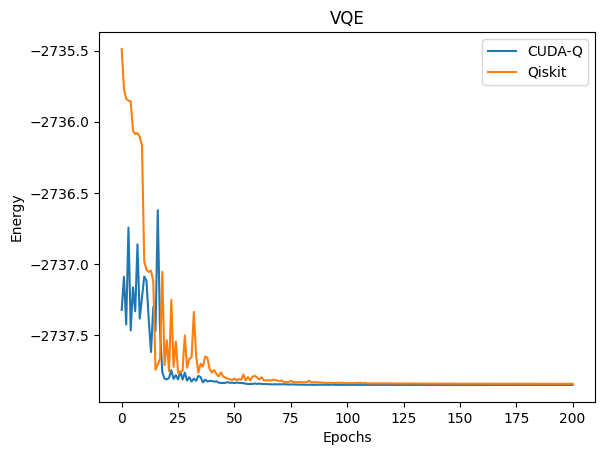

In [ ]:
print(f"Converged Qiskit energy = {qiskit_exp_vals[-1]:8.6f}")
print(f"Converged CUDA-Q energy = {cudaq_exp_vals[-1]:8.6f}")
plt.plot(cudaq_exp_vals, label='CUDA-Q')
plt.plot(qiskit_exp_vals, label='Qiskit')

plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.legend()
plt.show()

In [ ]:

print(cudaq.draw(kernel, nocc, num_orbitals, initial_parameters, flatenned_ep))



     ╭───╮╭───╮╭───╮╭────────────╮╭───╮╭─────╮ ╭───╮ ╭───╮╭───────────╮╭───╮»
q0 : ┤ x ├┤ s ├┤ x ├┤ ry(-1.475) ├┤ x ├┤ sdg ├─┤ s ├─┤ x ├┤ ry(1.705) ├┤ x ├»
     ├───┤╰───╯╰─┬─╯╰────────────╯╰─┬─╯╰─────╯ ╰───╯ ╰─┬─╯╰───────────╯╰─┬─╯»
q1 : ┤ x ├───────┼──────────────────┼──────────────────┼─────────────────┼──»
     ├───┤       │                  │                  │                 │  »
q2 : ┤ x ├───────┼──────────────────┼──────────────────┼─────────────────┼──»
     ├───┤       │                  │                  │                 │  »
q3 : ┤ x ├───────┼──────────────────┼──────────────────┼─────────────────┼──»
     ├───┤╭───╮  │  ╭────────────╮  │   ╭───╮ ╭─────╮  │                 │  »
q4 : ┤ s ├┤ h ├──●──┤ ry(-1.475) ├──●───┤ h ├─┤ sdg ├──┼─────────────────┼──»
     ├───┤├───┤     ╰────────────╯      ╰───╯ ╰─────╯  │  ╭───────────╮  │  »
q5 : ┤ s ├┤ h ├────────────────────────────────────────●──┤ ry(1.705) ├──●──»
     ├───┤├───┤                                           ╰─────

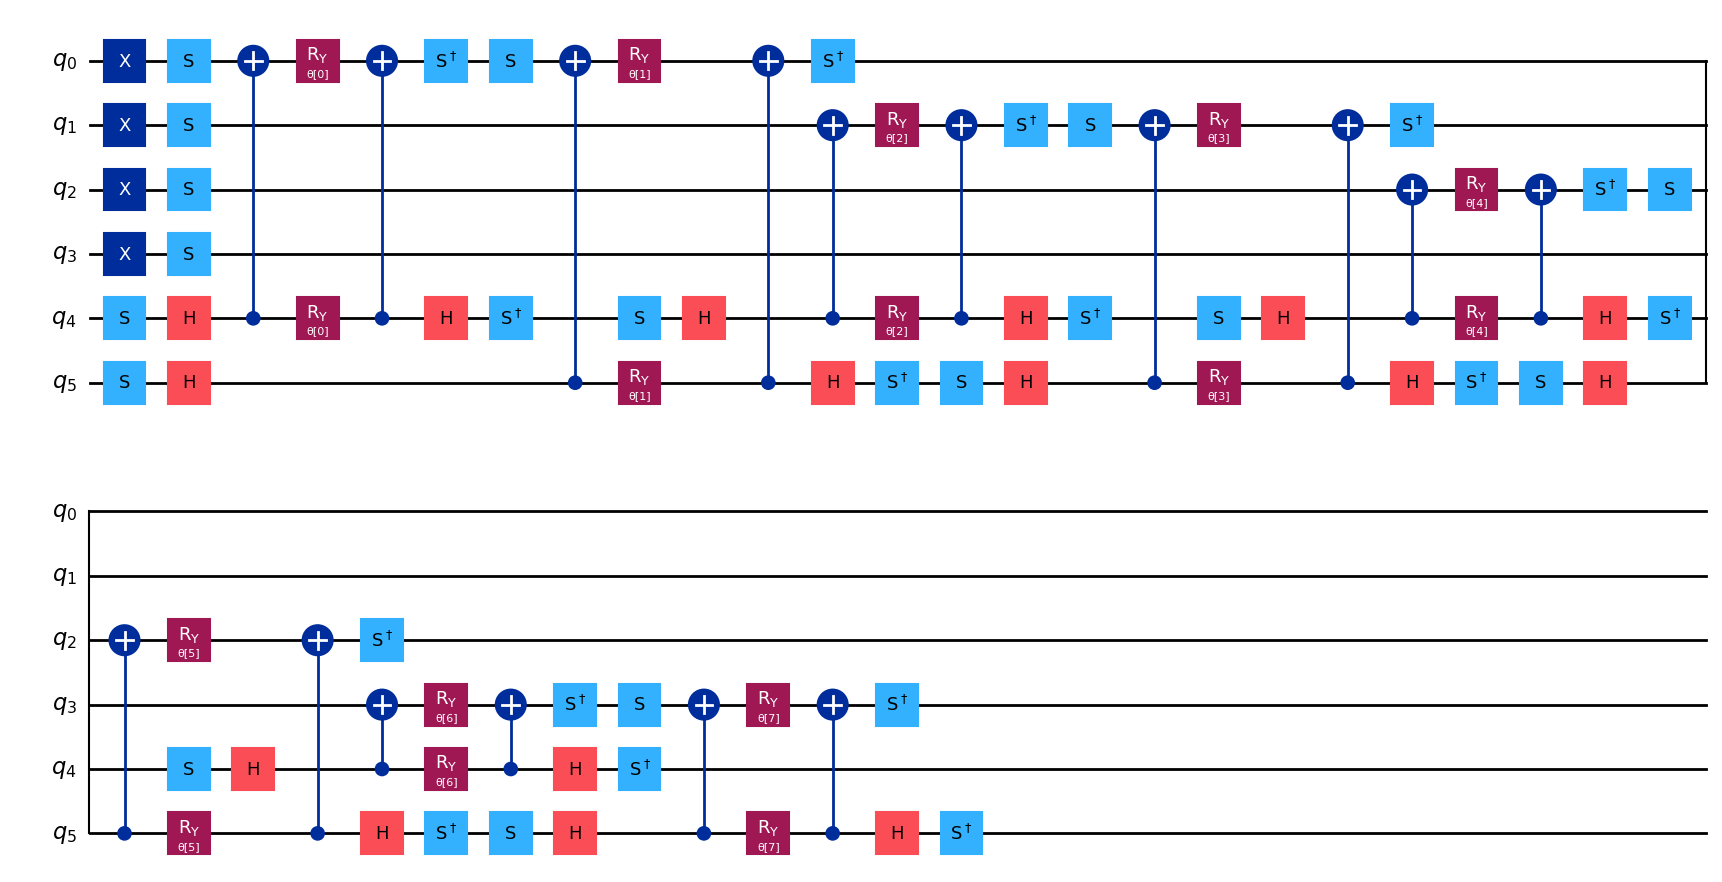

In [ ]:
circuit.draw(output="mpl")